# From JSON to GeoTIFF

This script is to create TIFF from JSON generated in GH

PSEUDOCODE
- Import library
- Import json file (saved from grasshopper)
- Create Dataset with Numpy
- Visualize the result 2d
- Visualize result 3d (optional)
- Give reference coordinate (Georeference)
- Create and save DSM.TIFF

Import libraries

Import JSON

--- Processing dsm_000deg.json ---
  Rasterizing 2 buildings...
Saved DSM and DEM for dsm_000deg
Max height in DSM: 50.00m
✅ Exported GeoJSONs for dsm_000deg


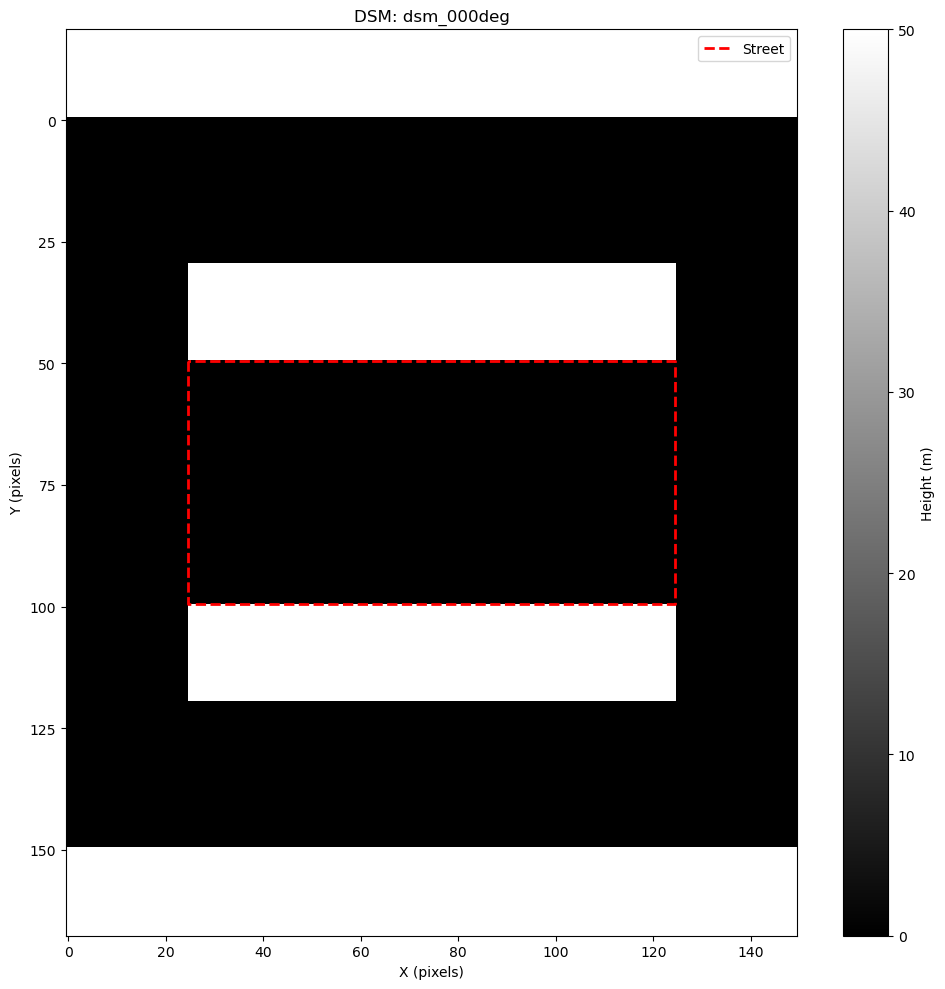

--- Processing dsm_045deg.json ---
  Rasterizing 2 buildings...
Saved DSM and DEM for dsm_045deg
Max height in DSM: 50.00m
✅ Exported GeoJSONs for dsm_045deg


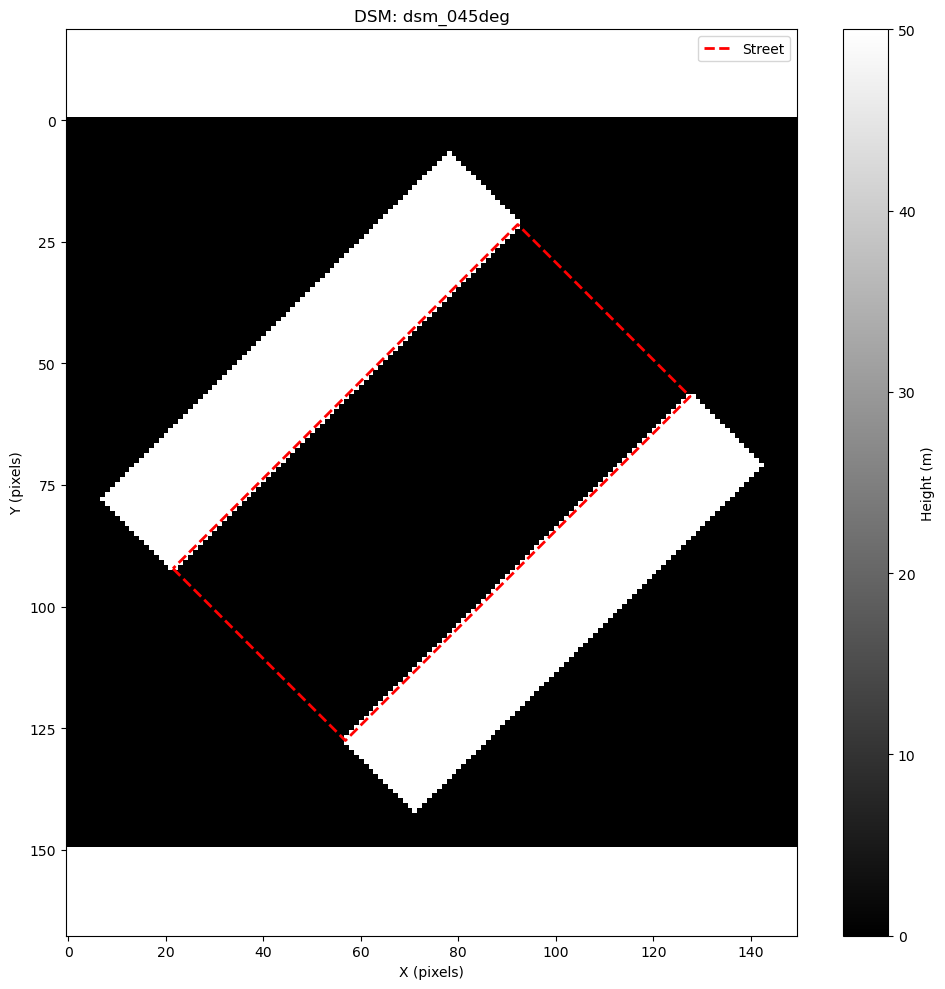

--- Processing dsm_090deg.json ---
  Rasterizing 2 buildings...
Saved DSM and DEM for dsm_090deg
Max height in DSM: 50.00m
✅ Exported GeoJSONs for dsm_090deg


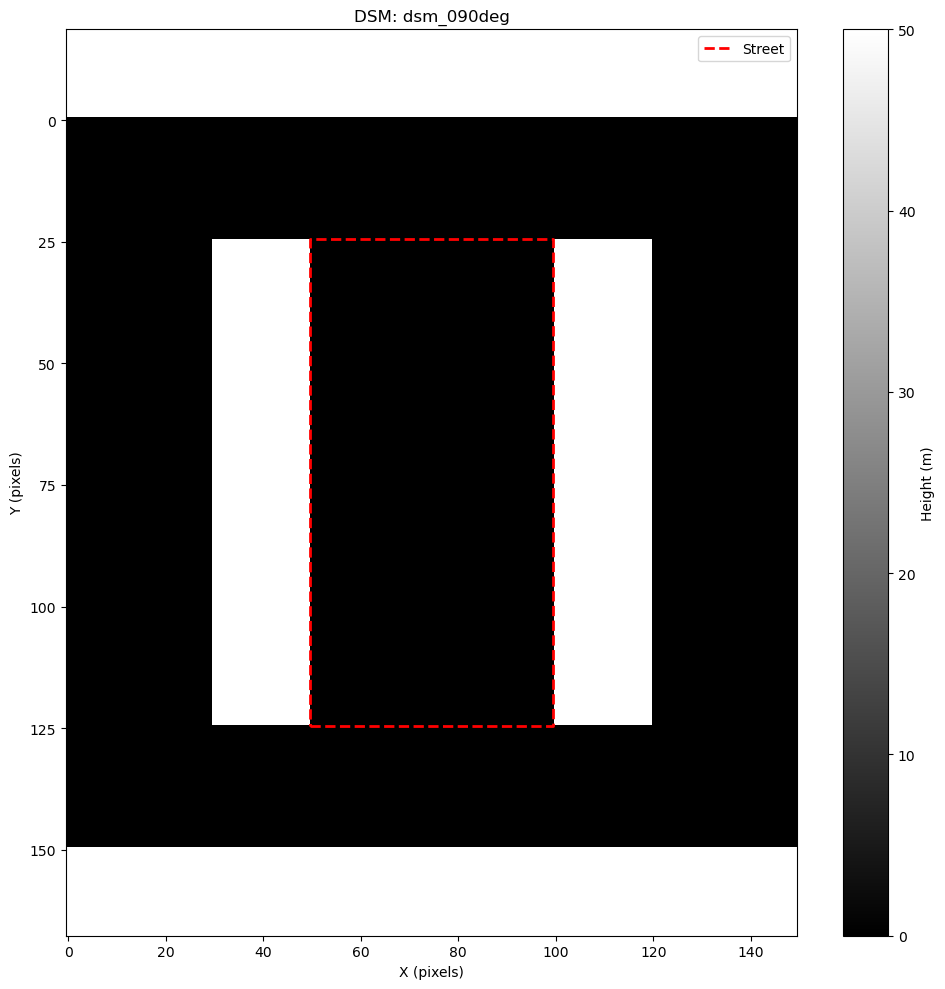

--- Processing dsm_135deg.json ---
  Rasterizing 2 buildings...
Saved DSM and DEM for dsm_135deg
Max height in DSM: 50.00m
✅ Exported GeoJSONs for dsm_135deg


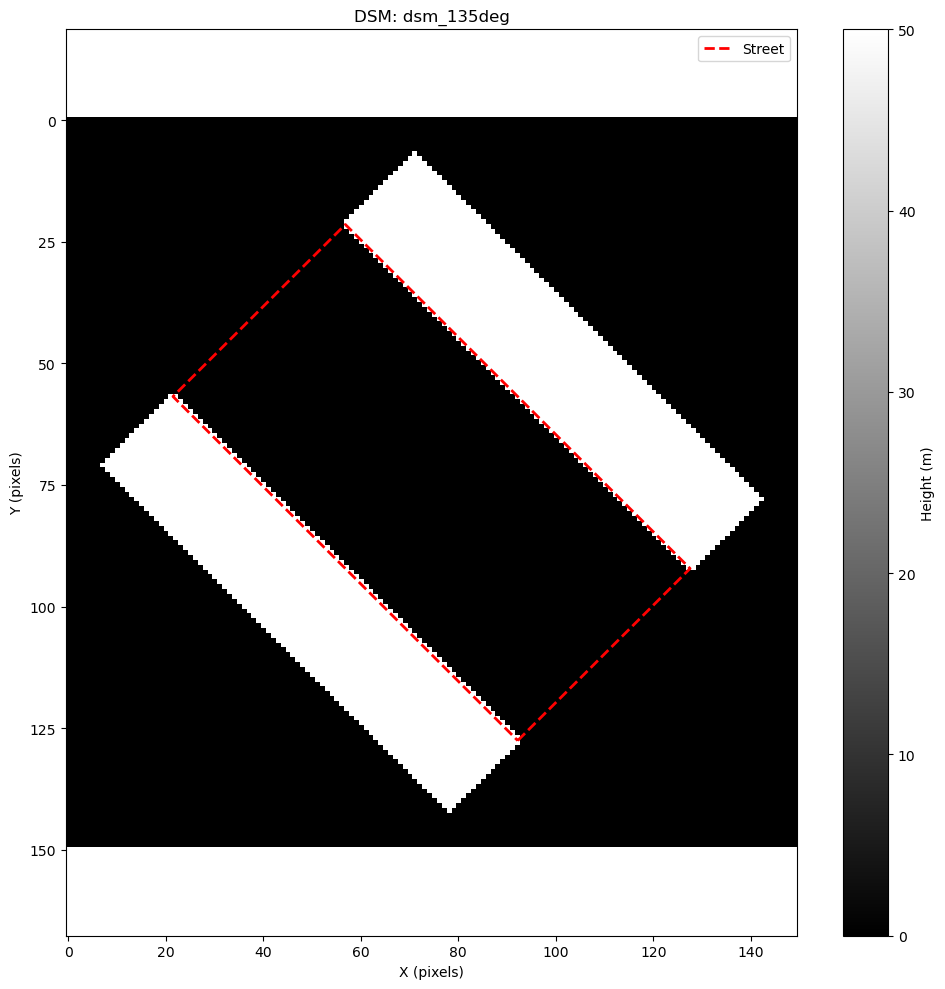


--- All files processed successfully! ---


In [8]:
import os
import json
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import fiona
from fiona.crs import from_epsg
from shapely.geometry import mapping

geojson_folder = os.path.join(input_folder, "geojson_export")
os.makedirs(geojson_folder, exist_ok=True)

# SETUP & CONFIGURATION

# INPUT FOLDER
input_folder = r"C:\Users\Andrea\Desktop\thesis\rotated_json"

# REAL-WORLD ORIGIN & CRS
# Using Barcelona's approximate UTM 31N coordinates as the anchor point
utm_x_origin = 430000  # Easting
utm_y_origin = 4580000  # Northing
CRS = "EPSG:25831"      # Coordinate Reference System for UTM 31N

# MAIN PROCESSING LOOP

for file in os.listdir(input_folder):
    if not file.endswith(".json"):
        continue

    print(f"--- Processing {file} ---")
    json_path = os.path.join(input_folder, file)

    # Load Data from JSON
    
    with open(json_path, "r") as f:
        data = json.load(f)

    cell_size = data["cell_size"]
    plane_width, plane_height = data["plane_size"]
    buildings = data["buildings"]
    street = data.get("street", None)

    cols = int(np.ceil(plane_width / cell_size))
    rows = int(np.ceil(plane_height / cell_size))

    
    # Create Coordinate Transforms

    # Transform for the LOCAL coordinate system (used for the rasterize step)
    # The origin is the top-left corner of the plane in its own local space.
    local_transform = from_origin(-plane_width / 2, plane_height / 2, cell_size, cell_size)

    # Transform for the WORLD coordinate system (used for saving the GeoTIFF)
    # The origin is the top-left corner of the plane in real-world UTM coordinates.
    world_x_top_left = utm_x_origin - plane_width / 2
    world_y_top_left = utm_y_origin + plane_height / 2
    world_transform = from_origin(world_x_top_left, world_y_top_left, cell_size, cell_size)

    
    # Prepare Building Shapes for Rasterization
    
    shapes_and_heights = []
    if buildings:
        for b in buildings:
            footprint = b.get("footprint")
            height = float(b.get("height", 0))

            if not footprint or height == 0:
                continue
            
            poly = Polygon(footprint)
            if poly.is_valid:
                shapes_and_heights.append((poly, height))
            else:
                print(f"Invalid polygon skipped in {file}")
    
    
    # Rasterize Buildings into DSM
    
    if shapes_and_heights:
        print(f"  Rasterizing {len(shapes_and_heights)} buildings...")
        dsm = rasterize(
            shapes=shapes_and_heights,
            out_shape=(rows, cols),
            transform=local_transform,
            fill=0,
            dtype=np.float32,
            all_touched=True
        )
    else:
        print(f"No valid buildings found. Creating empty DSM.")
        dsm = np.zeros((rows, cols), dtype=np.float32)

    # Save Digital Surface Model (DSM)
    
    base_name = os.path.splitext(file)[0]
    dsm_npy_path = os.path.join(input_folder, f"{base_name}.npy")
    dsm_tif_path = os.path.join(input_folder, f"{base_name}.tif")
    
    np.save(dsm_npy_path, dsm)
    
    with rasterio.open(
        dsm_tif_path, "w", driver="GTiff", height=rows, width=cols,
        count=1, dtype=dsm.dtype, crs=CRS, transform=world_transform
    ) as dst:
        dst.write(dsm, 1)

    # Create and Save Digital Elevation Model (DEM)
    
    dem = np.zeros_like(dsm, dtype=np.float32)
    dem_base_name = base_name.replace("dsm", "dem")
    dem_npy_path = os.path.join(input_folder, f"{dem_base_name}.npy")
    dem_tif_path = os.path.join(input_folder, f"{dem_base_name}.tif")

    np.save(dem_npy_path, dem)

    with rasterio.open(
        dem_tif_path, "w", driver="GTiff", height=rows, width=cols,
        count=1, dtype=dem.dtype, crs=CRS, transform=world_transform
    ) as dst:
        dst.write(dem, 1)
        
    print(f"Saved DSM and DEM for {base_name}")
    print(f"Max height in DSM: {dsm.max():.2f}m")

    # 🔁 EXPORT GEOJSONs for this file

# Convert street to UTM polygon
    street_geom = None
    if street:
        street_utm_coords = [(utm_x_origin + x, utm_y_origin + y) for x, y in street]
        poly = Polygon(street_utm_coords)
        if poly.is_valid:
            street_geom = mapping(poly)

# Convert building footprints to UTM with height
    building_features = []
    if buildings:
        for b in buildings:
            footprint = b.get("footprint")
            height = float(b.get("height", 0))
            if footprint and height > 0:
                poly = Polygon([(utm_x_origin + x, utm_y_origin + y) for x, y in footprint])
                if poly.is_valid:
                    building_features.append({
                        "geometry": mapping(poly),
                        "properties": {
                            "height": height,
                            "source": base_name
                        }
                    })

# 1️⃣ Export street-only GeoJSON
    if street_geom:
        street_path = os.path.join(geojson_folder, f"{base_name}_street.geojson")
        schema = {
            "geometry": "Polygon",
            "properties": {"id": "str"}
        }
        with fiona.open(street_path, "w", driver="GeoJSON", crs=from_epsg(25831), schema=schema) as layer:
            layer.write({
                "geometry": street_geom,
                "properties": {"id": base_name}
            })

# 2️⃣ Export buildings-only GeoJSON
    if building_features:
        bld_path = os.path.join(geojson_folder, f"{base_name}_buildings.geojson")
        schema = {
            "geometry": "Polygon",
            "properties": {"height": "float", "source": "str"}
        }
        with fiona.open(bld_path, "w", driver="GeoJSON", crs=from_epsg(25831), schema=schema) as layer:
            for feat in building_features:
                layer.write(feat)

# 3️⃣ Export combined GeoJSON (street + buildings)
    combined_path = os.path.join(geojson_folder, f"{base_name}_full.geojson")
    schema = {
        "geometry": "Polygon",
        "properties": {
            "type": "str",  # "street" or "building"
            "height": "float",
            "source": "str"
        }
    }
    with fiona.open(combined_path, "w", driver="GeoJSON", crs=from_epsg(25831), schema=schema) as layer:
        if street_geom:
            layer.write({
                "geometry": street_geom,
                "properties": {"type": "street", "height": 0.0, "source": base_name}
            })
        for feat in building_features:
            layer.write({
                "geometry": feat["geometry"],
                "properties": {
                    "type": "building",
                    "height": feat["properties"]["height"],
                    "source": base_name
                }
            })

    print(f"✅ Exported GeoJSONs for {base_name}")

    # Visualize DSM and Street Outline

    plt.figure(figsize=(10, 10))
    plt.imshow(dsm, cmap='grey', origin='upper')
    plt.title(f"DSM: {base_name}")
    plt.colorbar(label="Height (m)")

    if street:
        x_min_local = -plane_width / 2
        y_max_local = plane_height / 2
        
        adjusted_street = []
        for x, y in street:
            
            px = (x - x_min_local) / cell_size
            py = (y_max_local - y) / cell_size

            adjusted_street.append((px - 0.5, py - 0.5))
        
        poly = Polygon(adjusted_street)
        if poly.is_valid:
            x_coords, y_coords = poly.exterior.xy
            plt.plot(x_coords, y_coords, color='red', linewidth=2, linestyle='--', label="Street")

    plt.axis('equal')
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n--- All files processed successfully! ---")